In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import sys
import os
sys.path.append(os.path.abspath('../'))
from utils.parse_data import load_trained_model
from interp_helpers import plot_attribution_all_targets

%load_ext autoreload
%autoreload 2

In [4]:
sns.set_theme(
    style='ticks',
    font_scale=1.0,
    rc={'axes.labelsize': 11,
        'axes.titlesize': 11,
        'savefig.transparent': True,
        'legend.title_fontsize': 11,
        'legend.fontsize': 10,
        'legend.borderpad': 0.2,
        'figure.titlesize': 11,
        'figure.subplot.wspace': 0.1,
        })

## Input-scaled/activation-scaled gradient attribution

For a sequence input:
$$
\begin{align}
[x_0, x_1, ..., x_T]
\end{align}
$$

that produces output logits $y$ (with dimensionality equal to vocabulary size), we compute:
$$
\begin{align}
x_0 (∂y/∂x_0) \\
x_1 (∂y/∂x_1) \\
... \\
x_T (∂y/∂x_T)
\end{align}
$$

$x_i$ are actually embedding vectors, not the token indices themselves. We compute the gradients of the logit for a particular target with respect to each input embedding, then multiply each embedding by its corresponding gradient.

We then generalize this approach to all layers of the model, such that attribution is defined as the gradient at the layer of interest for a particular target, scaled by the activation at that layer.

In [5]:
# Load the model
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

run = 36 # fm.get_latest_run()
model, model_info, config = load_trained_model(run, model_name=None, device=device, weights_only=False)

Using cpu device


In [9]:
vocab = ['R', 'r', 'L', 'l']
stoi = {ch: i for i, ch in enumerate(vocab)}
itos = {i: ch for i, ch in enumerate(vocab)}
T = model_info['dataloader']['Sequence length (T)']

In [48]:
sequences = [
    'RRRRRR',
    'LLLLLL',
    'RRRRRr',
    'RRRRrr',
    'RRRrrr',
    'RRRrLr',
    'RRRrLL',
]

In [49]:
def compute_layer_attribution(model, sequence, stoi, target_token_idx, layers_of_interest=None):
    """
    Compute attributions for specified layers within the model.
    
    Args:
        model: The transformer model
        sequence: Input character sequence
        stoi: String to index mapping dictionary
        target_token_idx: Token index for which to compute attribution
        layers_of_interest: Dict mapping layer names to module paths or direct module references
                            If None, defaults to embedding layers
    
    Returns:
        Dictionary mapping layer names to attribution scores
    """

    def setup_hooks(layers_of_interest):

        # Track activations and gradients for each layer
        layer_activations = {name: [] for name in layers_of_interest}
        layer_gradients = {name: [] for name in layers_of_interest}
        hooks = []
        
        # Register hooks for all layers of interest
        for layer_name, layer_module in layers_of_interest.items():
            def make_forward_hook(name):
                def hook(module, inp, out):
                    out.requires_grad_(True)
                    layer_activations[name].append(out.detach().clone())
                    
                    # Create backward hook
                    def grad_hook(grad):
                        layer_gradients[name].append(grad.detach().clone())
                        return grad
                    
                    out.register_hook(grad_hook)
                    return out
                return hook
            
            # Register the forward hook
            hook = layer_module.register_forward_hook(make_forward_hook(layer_name))
            hooks.append(hook)

        return layer_activations, layer_gradients, hooks

    # Default to embedding layers if no layers specified
    if layers_of_interest is None:
        layers_of_interest = {
            'token_embedding': model.transformer.wte,
            'position_embedding': model.transformer.wpe
        }

    token_ids = [stoi[char] for char in sequence]
    input_tensor = torch.tensor(token_ids, dtype=torch.long).unsqueeze(0).to(model.device)
    
    # Train mode for gradient tracking
    original_mode = model.training
    model.train()

    try:
        layer_activations, layer_gradients, hooks = setup_hooks(layers_of_interest)
        
        # Forward pass (without targets to avoid computing loss)
        logits, _ = model(input_tensor, targets=None)
        
        # Create a target for the specific output token
        target = torch.zeros_like(logits)  # [batch, seq_len, vocab]
        target[0, -1, target_token_idx] = 1.0
        
        model.zero_grad()
        
        # Backward pass for this specific output logit
        logits.backward(target, retain_graph=True)
        
        # Compute attributions for each layer
        attributions = {}
        for layer_name in layers_of_interest:
            if layer_activations[layer_name] and layer_gradients[layer_name]:
                # Element-wise multiplication and sum along feature dimension
                layer_activation = layer_activations[layer_name][0]
                layer_gradient = layer_gradients[layer_name][0]
                attribution = (layer_activation * layer_gradient).sum(dim=-1)
                attributions[layer_name] = attribution.cpu().numpy().squeeze()
            else:
                print(f"Warning: No activations or gradients captured for {layer_name}")
                attributions[layer_name] = None

        if ('token_embedding' in layers_of_interest.keys()) & ('position_embedding' in layers_of_interest.keys()):
            attributions['combined'] = attributions['token_embedding'] + attributions['position_embedding']
    finally:
        for hook in hooks:
            hook.remove()
    
        model.train(original_mode)
    
    return attributions

In [50]:
def get_module_by_path(model, path):
    """Access a module using a string path"""
    modules = path.split('.')
    current = model
    for module in modules:
        if module.isdigit():
            current = current[int(module)]
        else:
            current = getattr(current, module)
    return current


In [56]:
layers_to_analyze = {
    'token_embedding': 'transformer.wte',
    'position_embedding': 'transformer.wpe',
    'layer0_attn': 'transformer.h.0.attn',
    'layer0_mlp': 'transformer.h.0.mlp',
}

layers_to_analyze = {name: get_module_by_path(model, path) for name, path in layers_to_analyze.items()}


In [52]:
model.transformer.named_modules

<bound method Module.named_modules of ModuleDict(
  (wte): Embedding(4, 4)
  (wpe): Embedding(6, 4)
  (h): ModuleList(
    (0): Block(
      (ln_1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
      (attn): CausalSelfAttention(
        (c_attn): Linear(in_features=4, out_features=12, bias=True)
        (c_proj): Linear(in_features=4, out_features=4, bias=True)
      )
      (ln_2): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (c_fc): Linear(in_features=4, out_features=16, bias=True)
        (gelu): GELU(approximate='tanh')
        (c_proj): Linear(in_features=16, out_features=4, bias=True)
      )
    )
  )
  (ln_f): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
)>

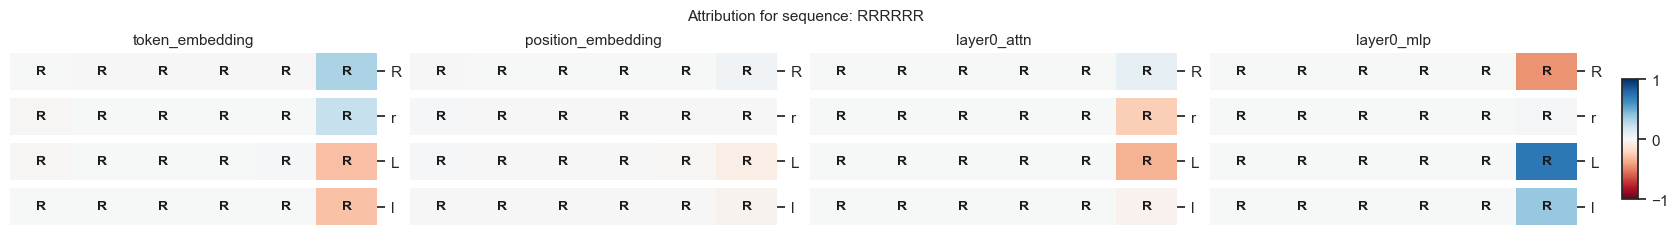

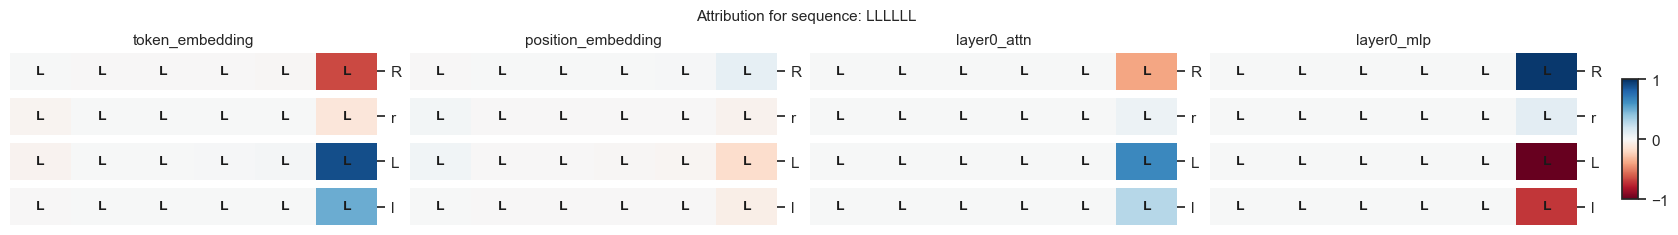

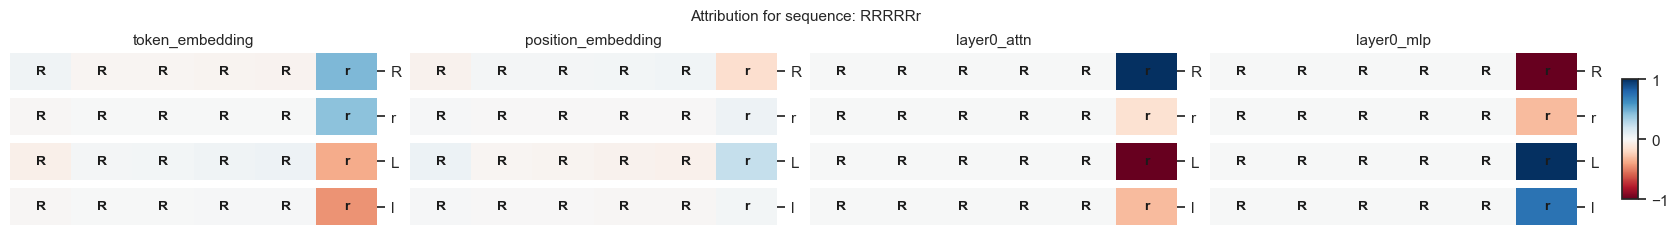

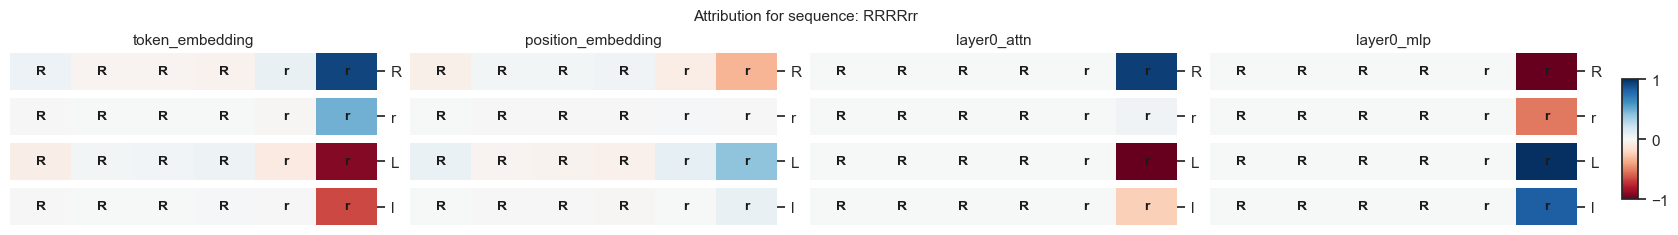

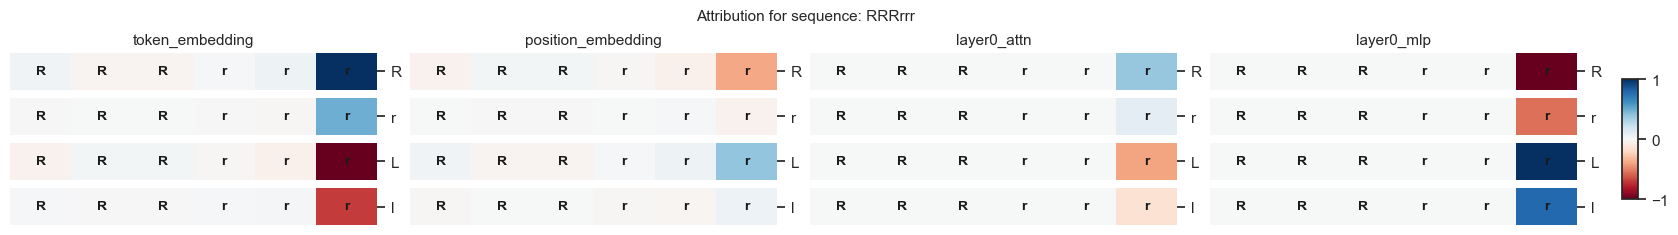

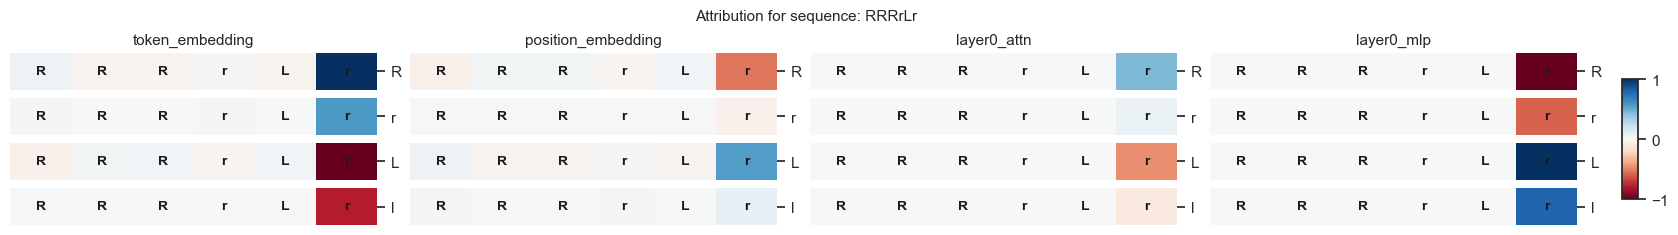

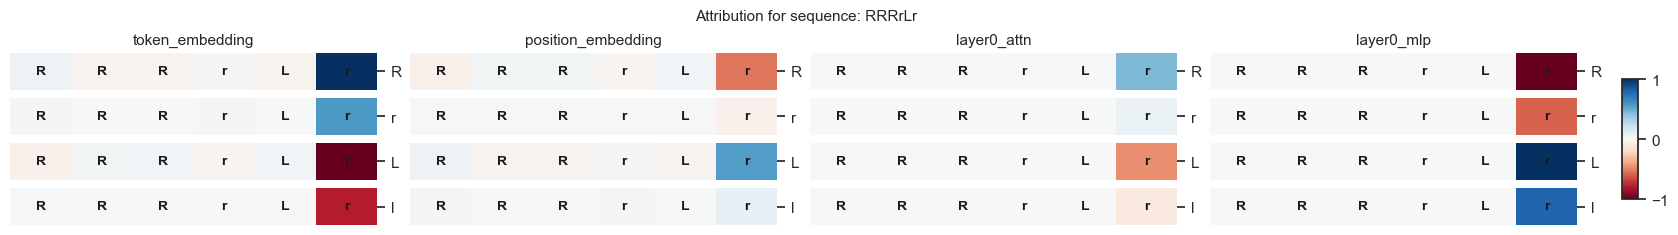

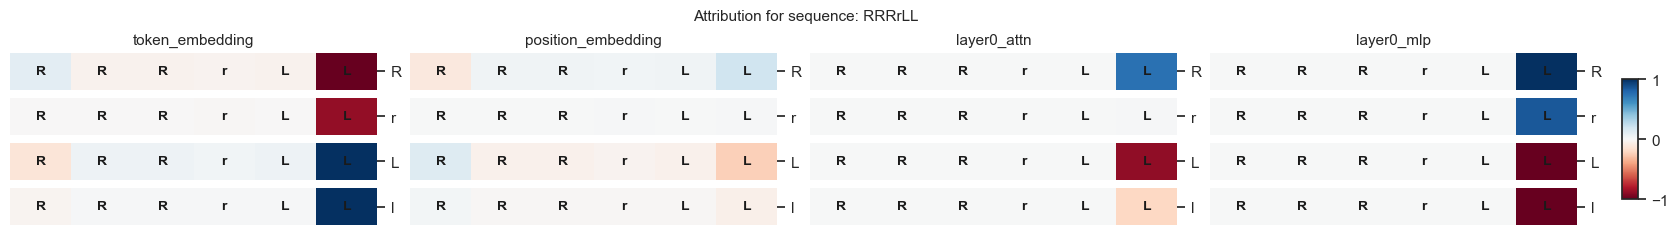

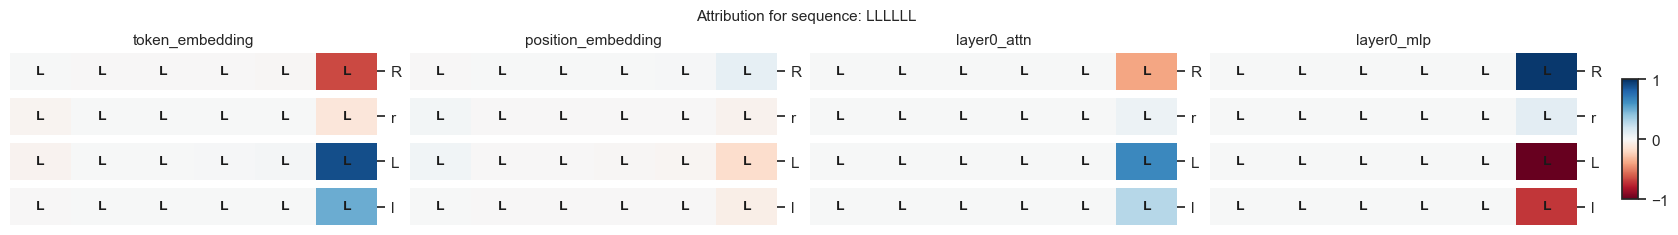

In [57]:
plot_attribution_all_targets(compute_layer_attribution, model, sequences, vocab, stoi, layers_of_interest=layers_to_analyze, ncols=len(layers_to_analyze))